In [1]:
from LegoRL import *

In [2]:
import gym
env = gym.make('CartPole-v0').unwrapped

In [3]:
import torch
import torch.nn as nn

CartpoleNN = lambda input_size, output_size: nn.Sequential(
                nn.Linear(input_size, 128),
                nn.ReLU(),
                nn.Linear(128, 128),
                nn.ReLU(),
                nn.Linear(128, output_size)
)

In [4]:
CartpoleBackboneNN = lambda input_size, output_size: nn.Sequential(
                nn.Linear(input_size, 128),
                nn.ReLU(),
                nn.Linear(128, output_size),
                nn.ReLU(),
)

In [5]:
NoisyCartpoleBackboneNN = lambda input_size, output_size: nn.Sequential(
                NoisyLinearRT()(input_size, 20),
                nn.ReLU(),
                NoisyLinearRT()(20, output_size),
                nn.ReLU()
)

# DQN (without Target network)

In [10]:
class VanilaDQN(System):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.runner    = Runner(self)
        self.egreedy   = eGreedy(self)        
        self.q_network = QNetwork(self, CartpoleNN)
        self.replay    = ReplayBuffer(self)
        self.sampler   = Sampler(self, self.replay)
        self.target    = OneStep(self)
        self.loss      = CriticLoss(self)
        self.trainer   = Trainer(self, models=self.q_network)
    
    def iteration(self):
        # Data collection---------------------------------------------------------------
        with torch.no_grad():
            actions = self.q_network(self.runner.states).greedy()
            actions = self.egreedy(actions)

            transition = self.runner.step(actions)
            self.replay.store(transition)
        
        # Training ---------------------------------------------------------------------
        batch = self.sampler.sample()
        if batch:
            prediction = self.q_network.Q(batch.states, batch.actions)
            target = self.target(self.q_network, **batch)
            loss = self.loss(prediction, target)
            self.trainer.optimize(loss)

In [11]:
dqn = VanilaDQN(env)
visualizer = Visualizer(dqn)

Initializing <QNetwork>:
  Input shape is torch.Size([4])
  Output shape is torch.Size([2])


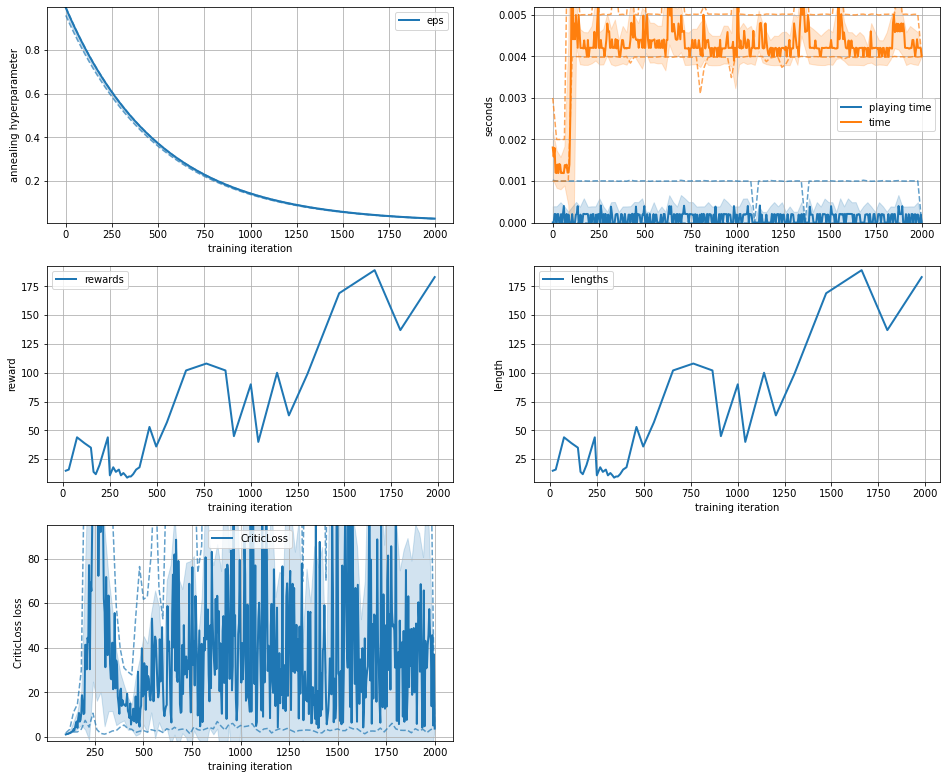

In [12]:
dqn.run(2000)

In [13]:
dqn.runner.fps

237.69893729526942

# DQN

In [18]:
class DQN(System):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.runner         = Runner(self)
        self.egreedy        = eGreedy(self)        
        self.q_network      = QNetwork(self, CartpoleNN)
        self.target_network = Frozen(self, self.q_network)
        self.replay         = ReplayBuffer(self)
        self.sampler        = Sampler(self, self.replay)
        self.target         = OneStep(self)
        self.loss           = CriticLoss(self)
        self.trainer        = Trainer(self, models=self.q_network)
    
    def iteration(self):
        # Data collection---------------------------------------------------------------
        with torch.no_grad():
            actions = self.q_network(self.runner.states).greedy()
            actions = self.egreedy(actions)

            transition = self.runner.step(actions)
            self.replay.store(transition)
        
        # Training ---------------------------------------------------------------------
        batch = self.sampler.sample()
        if batch:
            prediction = self.q_network.Q(batch.states, batch.actions)
            target = self.target(self.target_network, **batch)
            loss = self.loss(prediction, target)
            self.trainer.optimize(loss)
            
        # Target network update --------------------------------------------------------
        self.target_network.update()

In [19]:
dqn = DQN(env)
visualizer = Visualizer(dqn)

Initializing <QNetwork>:
  Input shape is torch.Size([4])
  Output shape is torch.Size([2])


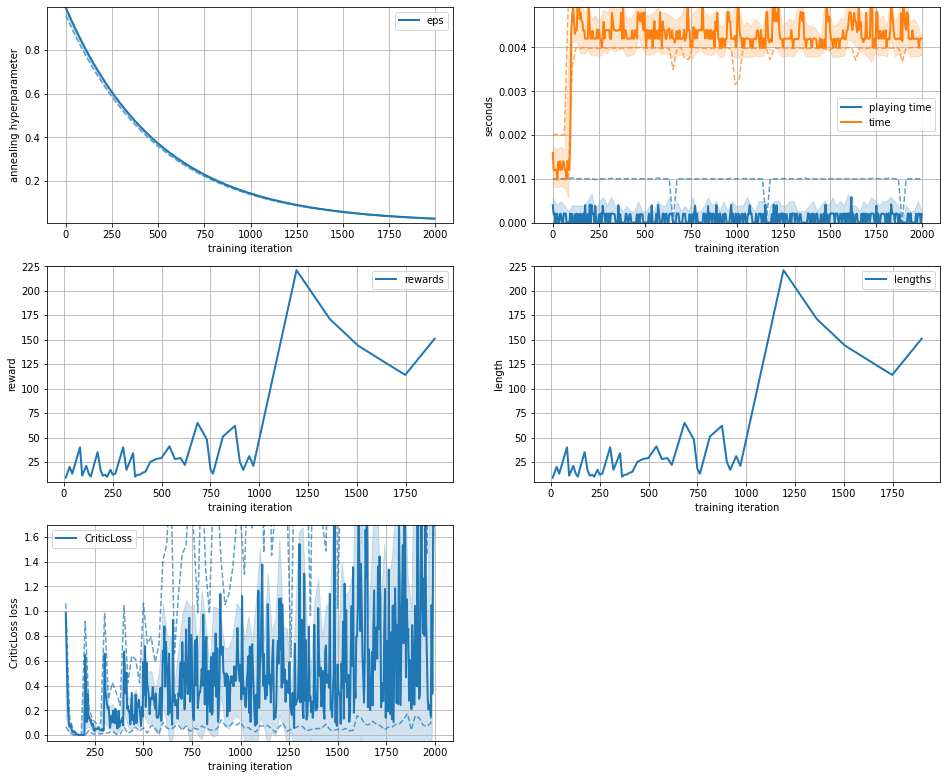

In [20]:
dqn.run(2000)

In [21]:
dqn.runner.fps

238.66105715372933

# Double DQN

In [29]:
class DoubleDQN(System):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.runner         = Runner(self)
        self.egreedy        = eGreedy(self)        
        self.q_network      = QNetwork(self, CartpoleNN)
        self.target_network = Frozen(self, self.q_network)
        self.replay         = ReplayBuffer(self)
        self.sampler        = Sampler(self, self.replay)
        self.double         = Double(self)
        self.loss           = CriticLoss(self)
        self.trainer        = Trainer(self, models=self.q_network)
    
    def iteration(self):
        # Data collection---------------------------------------------------------------
        with torch.no_grad():
            actions = self.q_network(self.runner.states).greedy()
            actions = self.egreedy(actions)

            transition = self.runner.step(actions)
            self.replay.store(transition)
        
        # Training ---------------------------------------------------------------------
        batch = self.sampler.sample()
        if batch:
            prediction = self.q_network.Q(batch.states, batch.actions)
            target = self.double(self.target_network, self.q_network, **batch)
            loss = self.loss(prediction, target)
            self.trainer.optimize(loss)
            
        # Target network update --------------------------------------------------------
        self.target_network.update()

In [30]:
dqn = DoubleDQN(env)
visualizer = Visualizer(dqn)

Initializing <QNetwork>:
  Input shape is torch.Size([4])
  Output shape is torch.Size([2])


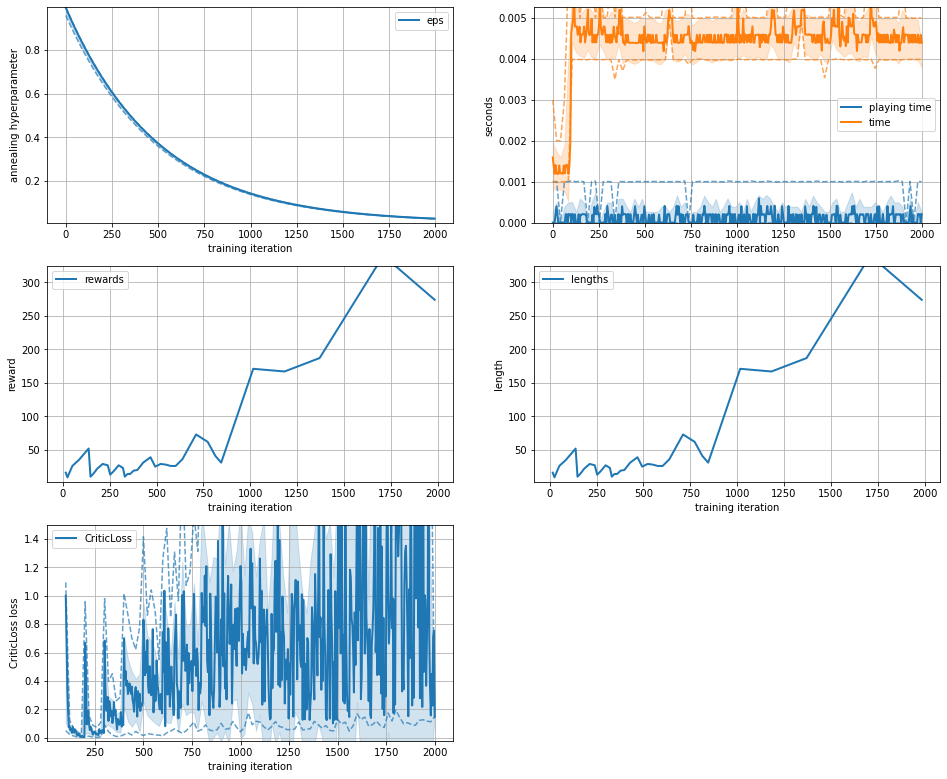

In [31]:
dqn.run(2000)

In [32]:
dqn.runner.fps

226.32739300263043

# Dueling Double DQN

In [9]:
class DuelingNet(RLmodule, QCritic):
    def __init__(self, par):
        RLmodule.__init__(self, par)
        QCritic.__init__(self)
        
        self.backbone = Model(self, CartpoleBackboneNN, output=Embedding(64))
        self.q_head   = QNetwork(self, input=Embedding(64))
        self.v_head   = VNetwork(self, input=Embedding(64))
        self.duel     = Dueling(self)
                
    def __call__(self, states):
        embedding = self.backbone(states)
        q = self.q_head(embedding)
        v = self.v_head(embedding)
        return self.duel(q, v)

In [10]:
class DuelingDQN(System):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.runner         = Runner(self)
        self.egreedy        = eGreedy(self) 
        self.q_network      = DuelingNet(self)
        self.target_network = Frozen(self, self.q_network)
        self.replay         = ReplayBuffer(self)
        self.sampler        = Sampler(self, self.replay)
        self.double         = Double(self)
        self.loss           = CriticLoss(self)
        self.trainer        = Trainer(self, models=self.q_network)
    
    def iteration(self):
        # Data collection---------------------------------------------------------------
        with torch.no_grad():
            actions = self.q_network(self.runner.states).greedy()
            actions = self.egreedy(actions)

            transition = self.runner.step(actions)
            self.replay.store(transition)
        
        # Training ---------------------------------------------------------------------
        batch = self.sampler.sample()
        if batch:
            prediction = self.q_network.Q(batch.states, batch.actions)
            target = self.double(self.target_network, self.q_network, **batch)
            loss = self.loss(prediction, target)
            self.trainer.optimize(loss)
            
        # Target network update --------------------------------------------------------
        self.target_network.update()

In [11]:
dqn = DuelingDQN(env)
visualizer = Visualizer(dqn)

Initializing <Model>:
  Input shape is torch.Size([4])
  Output shape is torch.Size([64])
Initializing <QNetwork>:
  Input shape is torch.Size([64])
  Output shape is torch.Size([2])
Initializing <VNetwork>:
  Input shape is torch.Size([64])
  Output shape is torch.Size([])


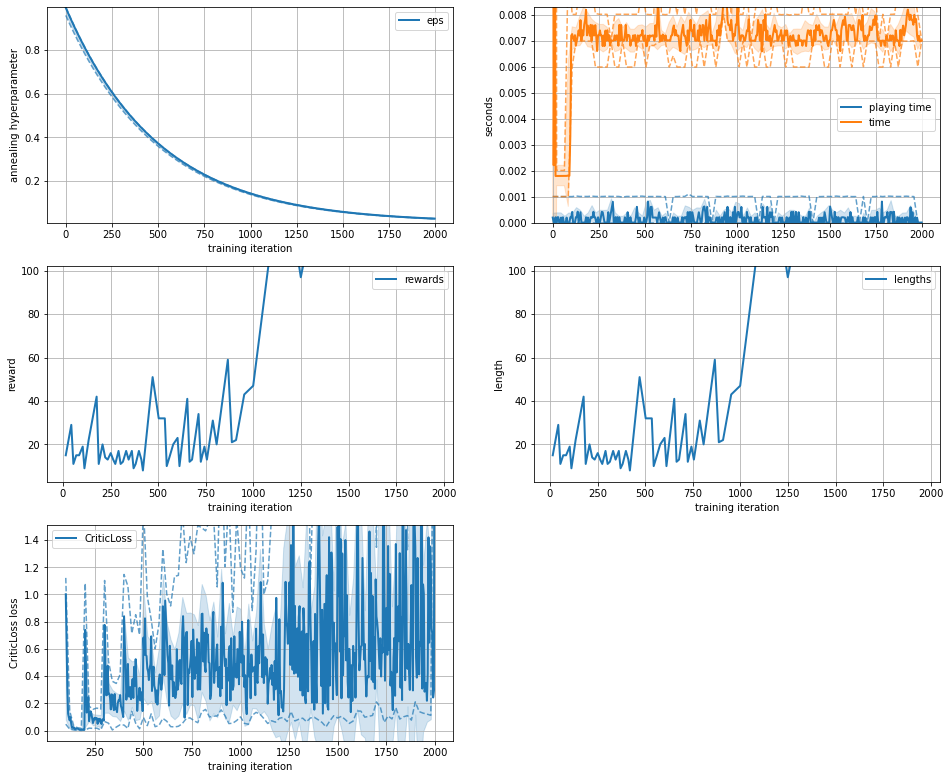

In [12]:
dqn.run(2000)

In [13]:
dqn.runner.fps

140.31032795998334

# Dueling Double DQN with PrioritizedReplay

In [17]:
class PrioritizedDQN(System):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.runner         = Runner(self)
        self.egreedy        = eGreedy(self)        
        self.q_network      = DuelingNet(self)
        self.target_network = Frozen(self, self.q_network)
        self.replay         = ReplayBuffer(self)
        self.sampler        = PrioritizedSampler(self, self.replay)
        self.correction     = SamplerBiasCorrection(self)
        self.double         = Double(self)
        self.loss           = CriticLoss(self)
        self.trainer        = Trainer(self, models=self.q_network)
    
    def iteration(self):
        # Data collection---------------------------------------------------------------
        with torch.no_grad():
            actions = self.q_network(self.runner.states).greedy()
            actions = self.egreedy(actions)

            transition = self.runner.step(actions)
            indices = self.replay.store(transition)
            self.sampler.expand(indices)
        
        # Training ---------------------------------------------------------------------
        batch = self.sampler.sample()
        if batch:
            prediction = self.q_network.Q(batch.states, batch.actions)
            target = self.double(self.target_network, self.q_network, **batch)
            weights = self.correction(batch.priorities)
            
            loss = self.loss(prediction, target, weights=weights)
            self.sampler.update_priorities(batch.indices, self.loss.last_batch_loss)
            
            self.trainer.optimize(loss)
            
        # Target network update --------------------------------------------------------
        self.target_network.update()

In [18]:
dqn = PrioritizedDQN(env)
visualizer = Visualizer(dqn)

Initializing <Model>:
  Input shape is torch.Size([4])
  Output shape is torch.Size([64])
Initializing <QNetwork>:
  Input shape is torch.Size([64])
  Output shape is torch.Size([2])
Initializing <VNetwork>:
  Input shape is torch.Size([64])
  Output shape is torch.Size([])


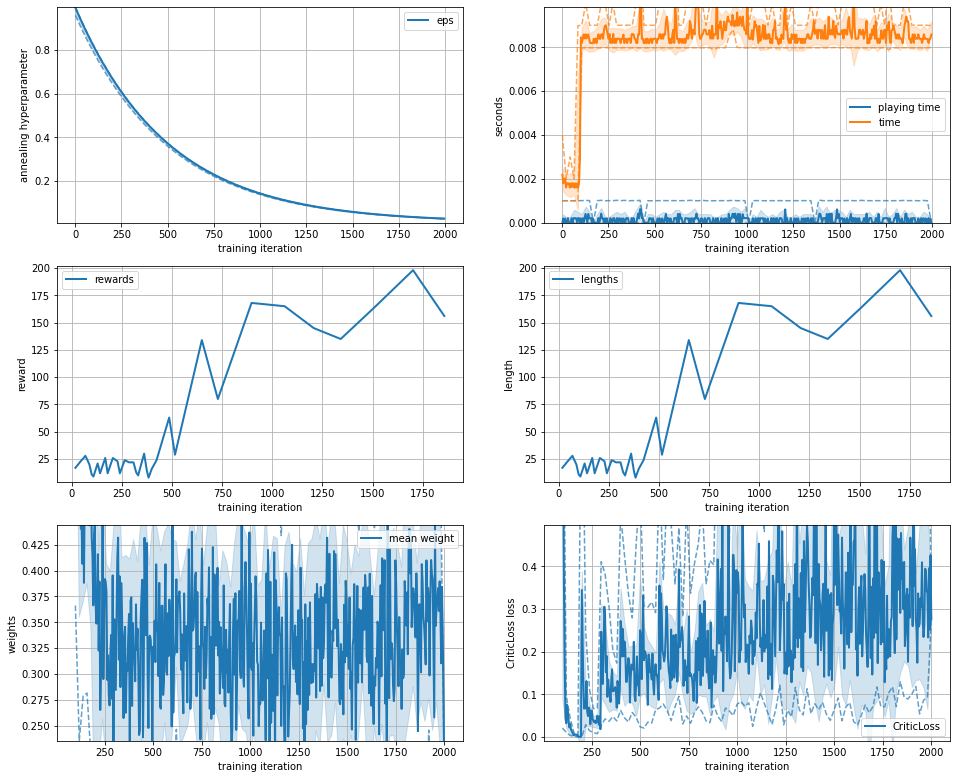

In [19]:
dqn.run(2000)

In [20]:
dqn.runner.fps

120.69517916697816

# N-step Dueling Double DQN with PrioritizedReplay

In [21]:
class NstepDQN(System):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.runner         = Runner(self)
        self.latency        = NstepLatency(self)
        self.egreedy        = eGreedy(self)        
        self.q_network      = DuelingNet(self)
        self.target_network = Frozen(self, self.q_network)
        self.replay         = ReplayBuffer(self)
        self.sampler        = PrioritizedSampler(self, self.replay)
        self.correction     = SamplerBiasCorrection(self)
        self.double         = Double(self)
        self.loss           = CriticLoss(self)
        self.trainer        = Trainer(self, models=self.q_network)
    
    def iteration(self):
        # Data collection---------------------------------------------------------------
        with torch.no_grad():
            actions = self.q_network(self.runner.states).greedy()
            actions = self.egreedy(actions)

            transition = self.runner.step(actions)
            transition = self.latency.add(transition)
            if transition:
                indices = self.replay.store(transition)
                self.sampler.expand(indices)
        
        # Training ---------------------------------------------------------------------
        batch = self.sampler.sample()
        if batch:
            prediction = self.q_network.Q(batch.states, batch.actions)
            target = self.double(self.target_network, self.q_network, **batch)
            weights = self.correction(batch.priorities)
            
            loss = self.loss(prediction, target, weights=weights)
            self.sampler.update_priorities(batch.indices, self.loss.last_batch_loss)
            
            self.trainer.optimize(loss)
            
        # Target network update --------------------------------------------------------
        self.target_network.update()

In [22]:
dqn = NstepDQN(env)
visualizer = Visualizer(dqn)

Initializing <Model>:
  Input shape is torch.Size([4])
  Output shape is torch.Size([64])
Initializing <QNetwork>:
  Input shape is torch.Size([64])
  Output shape is torch.Size([2])
Initializing <VNetwork>:
  Input shape is torch.Size([64])
  Output shape is torch.Size([])


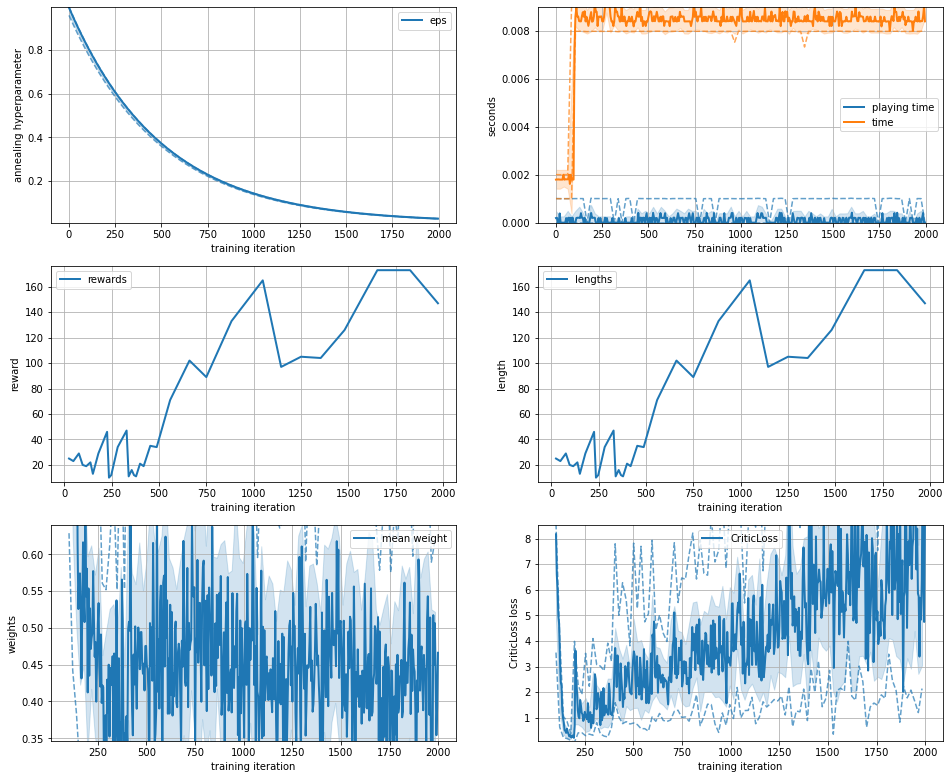

In [23]:
dqn.run(2000)

In [24]:
dqn.runner.fps

122.2142705822186

# Noisy N-step Dueling Double DQN with PrioritizedReplay

In [10]:
class NoisyDuelingNet(RLmodule, QCritic):
    def __init__(self, par):
        RLmodule.__init__(self, par)
        QCritic.__init__(self)
        
        self.backbone = Model(self, NoisyCartpoleBackboneNN, output=Embedding(64))
        self.q_head   = QNetwork(self, NoisyLinearRT(), input=Embedding(64))
        self.v_head   = VNetwork(self, NoisyLinearRT(), input=Embedding(64))
        self.duel     = Dueling(self)
                
    def __call__(self, states):
        embedding = self.backbone(states)
        q = self.q_head(embedding)
        v = self.v_head(embedding)
        return self.duel(q, v)

In [11]:
class NoisyNstepDQN(System):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.runner         = Runner(self)
        self.latency        = NstepLatency(self)
        self.egreedy        = eGreedy(self)        
        self.q_network      = NoisyDuelingNet(self)
        self.target_network = Frozen(self, self.q_network)
        self.replay         = ReplayBuffer(self)
        self.sampler        = PrioritizedSampler(self, self.replay)
        self.correction     = SamplerBiasCorrection(self)
        self.double         = Double(self)
        self.loss           = CriticLoss(self)
        self.trainer        = Trainer(self, models=self.q_network)
    
    def iteration(self):
        # Data collection---------------------------------------------------------------
        with torch.no_grad():
            actions = self.q_network(self.runner.states).greedy()
            actions = self.egreedy(actions)

            transition = self.runner.step(actions)
            transition = self.latency.add(transition)
            if transition:
                indices = self.replay.store(transition)
                self.sampler.expand(indices)
        
        # Training ---------------------------------------------------------------------
        batch = self.sampler.sample()
        if batch:
            prediction = self.q_network.Q(batch.states, batch.actions)
            target = self.double(self.target_network, self.q_network, **batch)
            weights = self.correction(batch.priorities)
            
            loss = self.loss(prediction, target, weights=weights)
            self.sampler.update_priorities(batch.indices, self.loss.last_batch_loss)
            
            self.trainer.optimize(loss)
            
        # Target network update --------------------------------------------------------
        self.target_network.update()

In [12]:
dqn = NoisyNstepDQN(env)
visualizer = Visualizer(dqn)

Initializing <Model>:
  Input shape is torch.Size([4])
  Output shape is torch.Size([64])
Initializing <QNetwork>:
  Input shape is torch.Size([64])
  Output shape is torch.Size([2])
Initializing <VNetwork>:
  Input shape is torch.Size([64])
  Output shape is torch.Size([])


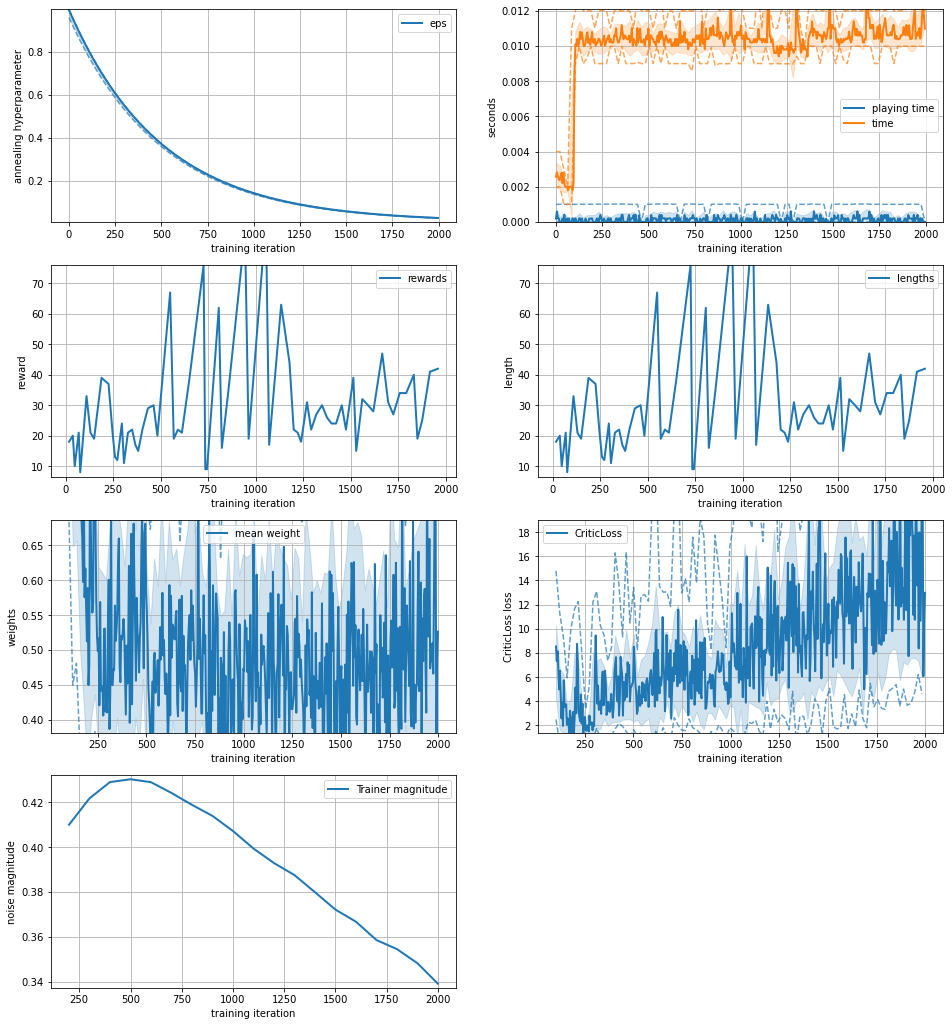

In [13]:
dqn.run(2000)

In [14]:
dqn.runner.fps

99.04731372053712

# Categorical DQN (also known as c51)

In [18]:
class c51(System):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.runner         = Runner(self)
        self.egreedy        = eGreedy(self)        
        self.q_network      = QNetwork(self, CartpoleNN, output=Categorical(Q, -10, 10, 51))
        self.target_network = Frozen(self, self.q_network)
        self.replay         = ReplayBuffer(self)
        self.sampler        = Sampler(self, self.replay)
        self.target         = OneStep(self)
        self.loss           = CriticLoss(self)
        self.trainer        = Trainer(self, models=self.q_network)
    
    def iteration(self):
        # Data collection---------------------------------------------------------------
        with torch.no_grad():
            actions = self.q_network(self.runner.states).greedy()
            actions = self.egreedy(actions)

            transition = self.runner.step(actions)
            self.replay.store(transition)
        
        # Training ---------------------------------------------------------------------
        batch = self.sampler.sample()
        if batch:
            prediction = self.q_network.Q(batch.states, batch.actions)
            target = self.target(self.target_network, **batch)
            loss = self.loss(prediction, target)
            self.trainer.optimize(loss)
            
        # Target network update --------------------------------------------------------
        self.target_network.update()

In [19]:
dqn = c51(env)
visualizer = Visualizer(dqn)

Initializing <QNetwork>:
  Input shape is torch.Size([4])
  Output shape is torch.Size([51, 2])


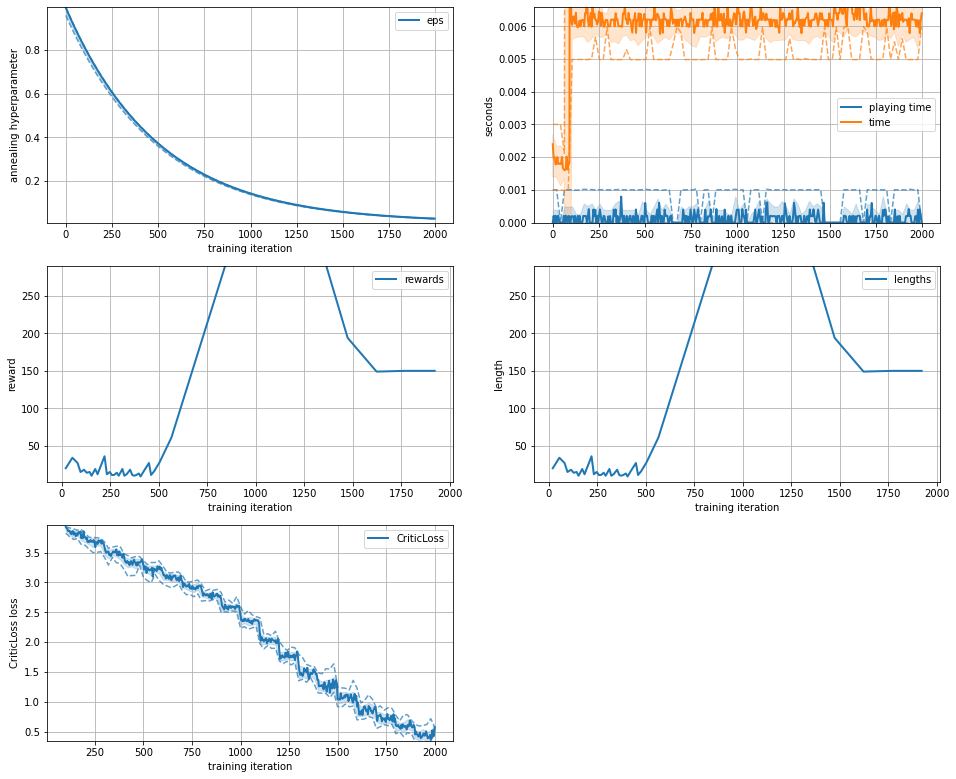

In [20]:
dqn.run(2000)

In [21]:
dqn.runner.fps

165.1735733639939

# Rainbow DQN

In [24]:
class NoisyDuelingCategoricalNet(RLmodule, QCritic):
    def __init__(self, par):
        RLmodule.__init__(self, par)
        QCritic.__init__(self)
        
        self.backbone = Model(self, NoisyCartpoleBackboneNN, output=Embedding(64))
        self.q_head   = QNetwork(self, NoisyLinearRT(), input=Embedding(64), output=Categorical(Q, -10, 10, 51))
        self.v_head   = VNetwork(self, NoisyLinearRT(), input=Embedding(64), output=Categorical(V, -10, 10, 51))
        self.duel     = Dueling(self)
                
    def __call__(self, states):
        embedding = self.backbone(states)
        q = self.q_head(embedding)
        v = self.v_head(embedding)
        return self.duel(q, v)

In [25]:
class Rainbow(System):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.runner         = Runner(self)
        self.latency        = NstepLatency(self)
        self.egreedy        = eGreedy(self)        
        self.q_network      = NoisyDuelingCategoricalNet(self)
        self.target_network = Frozen(self, self.q_network)
        self.replay         = ReplayBuffer(self)
        self.sampler        = PrioritizedSampler(self, self.replay)
        self.correction     = SamplerBiasCorrection(self)
        self.double         = Double(self)
        self.loss           = CriticLoss(self)
        self.trainer        = Trainer(self, models=self.q_network)
    
    def iteration(self):
        # Data collection---------------------------------------------------------------
        with torch.no_grad():
            actions = self.q_network(self.runner.states).greedy()
            actions = self.egreedy(actions)

            transition = self.runner.step(actions)
            transition = self.latency.add(transition)
            if transition:
                indices = self.replay.store(transition)
                self.sampler.expand(indices)
        
        # Training ---------------------------------------------------------------------
        batch = self.sampler.sample()
        if batch:
            prediction = self.q_network.Q(batch.states, batch.actions)
            target = self.double(self.target_network, self.q_network, **batch)
            weights = self.correction(batch.priorities)
            
            loss = self.loss(prediction, target, weights=weights)
            self.sampler.update_priorities(batch.indices, self.loss.last_batch_loss)
            
            self.trainer.optimize(loss)
            
        # Target network update --------------------------------------------------------
        self.target_network.update()

In [26]:
dqn = Rainbow(env)
visualizer = Visualizer(dqn)

Initializing <Model>:
  Input shape is torch.Size([4])
  Output shape is torch.Size([64])
Initializing <QNetwork>:
  Input shape is torch.Size([64])
  Output shape is torch.Size([51, 2])
Initializing <VNetwork>:
  Input shape is torch.Size([64])
  Output shape is torch.Size([51])


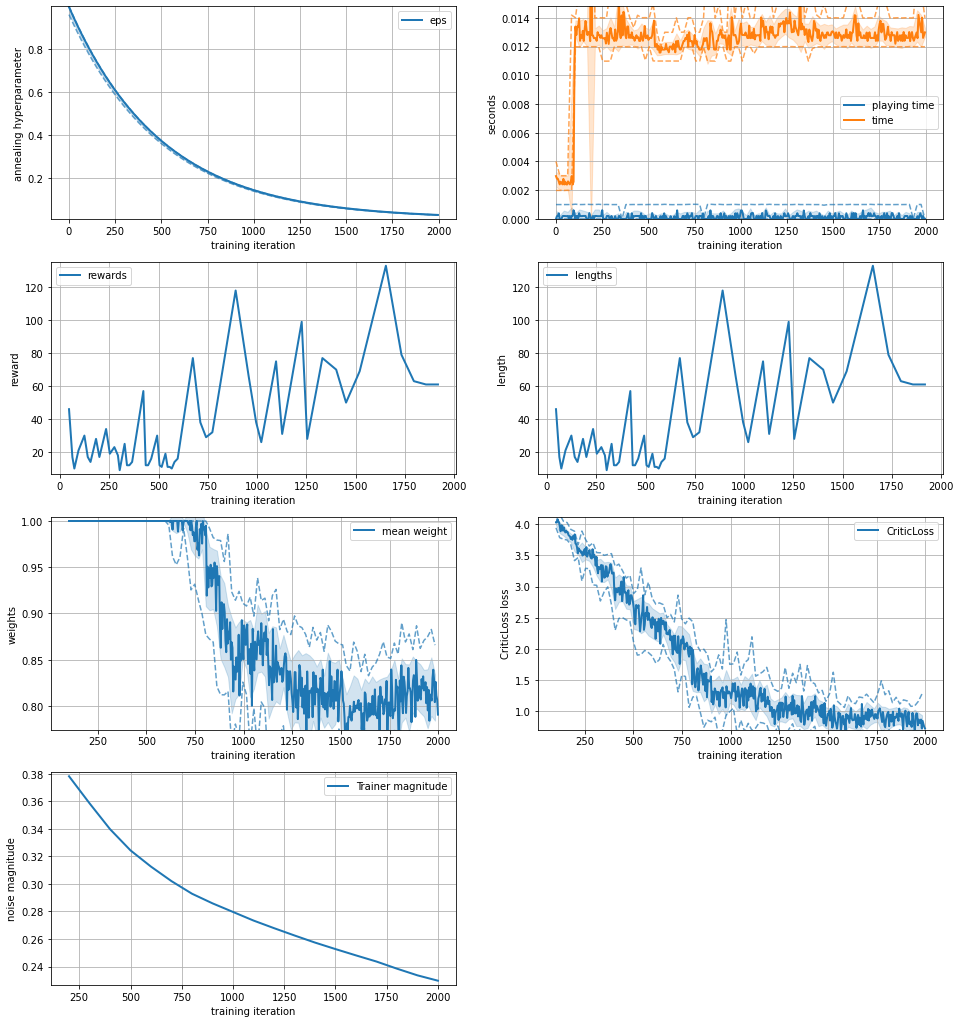

In [27]:
dqn.run(2000)

In [28]:
dqn.runner.fps

81.24639518255032

### All modules description:

In [29]:
dqn

<Runner>: Makes steps in 1 parallel environments
<NstepLatency>: Substitutes stream to 3-step transitions
<eGreedy>: Mixes actions with random actions
<NoisyDuelingCategoricalNet>:
    <NoisyDuelingCategoricalNet.Model>: Models Embedding of size 64
    <NoisyDuelingCategoricalNet.QNetwork>: Models Q-function in categorical from with 51 atoms from -10 to 10
    <NoisyDuelingCategoricalNet.VNetwork>: Models V-function in categorical from with 51 atoms from -10 to 10
    <NoisyDuelingCategoricalNet.Dueling>: Combines A and V in dueling form (V + A - A.mean())
    
<FrozenModule>:
    Frozen copy of <NoisyDuelingCategoricalNet>
<ReplayBuffer>: Stores data in raw numpy format
<PrioritizedSampler>: Samples mini-batch from <ReplayBuffer> using priorities
<SamplerBiasCorrection>: Adds weights to correct bias
<Double>: Decouples action selection and action evaluation
<CriticLoss>: Calculates TD loss
<Trainer>: Standard SGD loss optimization
<Visualizer>: Plots logs every 1000 iteration

In [30]:
dqn.hyperparameters()

{'Runner': {'num_envs': 1},
 'NstepLatency': {'n_steps': 3},
 'eGreedy': {'epsilon_start': 1, 'epsilon_final': 0.01, 'epsilon_decay': 500},
 'FrozenModule': {'timer': 100},
 'ReplayBuffer': {'capacity': 10000},
 'PrioritizedSampler': {'clip_priorities': 1, 'rp_alpha': 0.6},
 'SamplerBiasCorrection': {'rp_beta_start': 0.4, 'rp_beta_iterations': 100000},
 'CriticLoss': {'weight': 1},
 'Trainer': {'clip_gradients': None, 'optimizer': 'Adam'},
 'gamma': 0.99}